### Using a Variational Auto-encoder to predict protein fitness from evolutionary data

July 20, 2017
### Sam Sinai and Eric Kelsic


## For the blog post associated with this notebook see [this post](https://samsinai.github.io/jekyll/update/2017/08/14/Using-a-Variational-Autoencoder-to-predict-protein-function.html). 


This notebook it organized in 3 sections. In section 1 we show our workflow for pre-processing the biological data. We then train the model on the alignment data in section 2. In section 3 we compare the predictions of the model on the [PABP yeast](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3851721/) dataset. In section 4 we report the results from analyzing multiple other datasets. Finally we pose some questions with regards to improving the model for interested researcher.

In [5]:
# Generic imports
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math,random,re
import time
from sklearn.decomposition import PCA

from Bio import SeqIO

In [6]:
#Machine learning/Stats imports 
from scipy.stats import norm
from scipy.stats import spearmanr,pearsonr
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.distributions as D

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

In [70]:
from sklearn.ensemble import GradientBoostingRegressor

In [9]:
from models import *

In [10]:
import umap

In [11]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1.  Data pre-processing

Defining the alphabet that is used for Amino-Acids throughout.

In [12]:
#Invariants
ORDER_KEY="XILVAGMFYWEDQNHCRKSTPBZ-*"[::-1]
ORDER_LIST=list(ORDER_KEY)

These are helper functions to clean and process data. 

In [17]:
%reload_ext autoreload
%autoreload 1
from helper_tools import *
from helper_tools_for_plotting import *

Import the alignment data:

In [38]:
fowler = pd.read_csv("fowler_data.txt", delimiter="\t")

In [39]:
seqs = []
for record in SeqIO.parse("fowler_aligned_partial.fasta", "fasta"):
    seqs.append("".join(record.seq))

seqs.append(seqs[0])

data = pd.DataFrame({"sequence": seqs})

In [40]:
data.iloc[0]["sequence"]

'DLPLPPGWEMAYTENGRVYFIDHNTKTTTWLDPR'

Let's see how long the sequence is

In [41]:
print ("length of sequence:", len(data.iloc[0]["sequence"]))#, len(data.iloc[0]["seq"]))
print ("sample sequence: ", data.iloc[0]["sequence"])

length of sequence: 34
sample sequence:  DLPLPPGWEMAYTENGRVYFIDHNTKTTTWLDPR


We are only really interested in the columns that do align. This means that for every column that we include, at least 50% of sequences are not gaps. Note that this threshold is imposed by the alignment parameters loaded above. So let's make a column for that. Meanwhile, we keep track of the indices that did align.

In [42]:
indices=index_of_non_lower_case_dot(data.iloc[0]["sequence"])
data["seq"]=list(map(prune_seq,data["sequence"]))
data.head()

,sequence,seq
0,DLPLPPGWEMAYTENGRVYFIDHNTKTTTWLDPR,DLPLPPGWEMAYTENGRVYFIDHNTKTTTWLDPR
1,DVPLPAGWEMAKTRSGQRYFLNHVDQTTKWQDPR,DVPLPAGWEMAKTRSGQRYFLNHVDQTTKWQDPR
2,DVPLPAGWEMAKTSSGQRYFLNHIDQTTTWQDPR,DVPLPAGWEMAKTSSGQRYFLNHIDQTTTWQDPR
3,DVPLPAGWEMAKTSSGQRYFLNHIDQTTTWQDPR,DVPLPAGWEMAKTSSGQRYFLNHIDQTTTWQDPR
4,DVPLPAGWEMAKTSSGQRYFLNHIDQTTTWQDPR,DVPLPAGWEMAKTSSGQRYFLNHIDQTTTWQDPR


Let's see how many columns remained. 

In [43]:
print ("pruned sequence length:", len(data.iloc[0]["seq"]))
PRUNED_SEQ_LENGTH=len(data.iloc[0]["seq"])

pruned sequence length: 34


A few optional lines of code to run. Printing indices, and deleting the sequence column so that it doesn't stay in memory for no reason. 

Next we translate the sequence into a one hot encoding and shape the input sequences into a m*n matrix. Here m is the number of the data points and $n=$ alphbet size $\times$ sequence length.

In [44]:
#Encode Orthologs
ortholog_data_one_hot=[]
labels=[]
for i, row in data.iterrows():
    ortholog_data_one_hot.append(translate_string_to_one_hot(row["seq"],ORDER_LIST))
print (len(ortholog_data_one_hot),len(ortholog_data_one_hot[0]),len(ortholog_data_one_hot[0][0]))
#plt.imshow(training_data_one_hot[0],cmap="Greys")
ortholog_data=np.array([np.array(list(sample.T.flatten())) for sample in ortholog_data_one_hot])
print(ortholog_data.shape)

16668 25 34
(16668, 850)


In [45]:
#Encode fowler data to one hot
fowler_data_one_hot=[]
labels=[]
for i, row in fowler.iterrows():
    fowler_data_one_hot.append(translate_string_to_one_hot(row["sequence"],ORDER_LIST))
print (len(fowler_data_one_hot),len(fowler_data_one_hot[0]),len(fowler_data_one_hot[0][0]))
#plt.imshow(training_data_one_hot[0],cmap="Greys")
fowler_data=np.array([np.array(list(sample.T.flatten())) for sample in fowler_data_one_hot])
# training_data=np.array([np.array(list(sample.flatten())).T for sample in training_data_one_hot])
print(fowler_data.shape)

47000 25 34
(47000, 850)


## Basic Functions

In [205]:
def build_PCA(data, n_components):
    pca = PCA(n_components=n_components)
    pca.fit(data)
    return pca

def feed_PCA(pca, data):
    return pca.transform(data)

def split_data(xdata, ydata, train_size):
    x_train, x_test, y_train, y_test = train_test_split(xdata, ydata, train_size=train_size, random_state=10)
    return (x_train, x_test, y_train, y_test)

def train_test(x_train, x_test, y_train, y_test, model_type="reg"):
    if (model_type == "reg"):
        reg = GradientBoostingRegressor(max_depth=6)
        reg.fit(x_train, y_train)
        return (spearmanr(reg.predict(x_test), y_test))
#         return (reg.score(x_test, y_test))
    
    elif (model_type == "clf"):
        clf = RandomForestClassifier()
        clf.fit(x_train, y_train > 0.5)
        return (clf.score(x_test, y_test > 0.5))
    
    return None    

def augmented_learning(data, additional_data, labels, n_components, train_size):
    x_train, x_test, y_train, y_test = split_data(data, labels, train_size=train_size)
    
    augmented_data = np.concatenate([x_train, additional_data])
    pca = build_PCA(augmented_data, n_components=n_components)
    transformed_train = feed_PCA(pca, x_train)
    transformed_test = feed_PCA(pca, x_test)

    
    reg_score = train_test(transformed_train, transformed_test, y_train, y_test, model_type="reg")
    clf_score = train_test(transformed_train, transformed_test, y_train, y_test, model_type="clf")
    
    return (reg_score, clf_score)

def normal_learning(data, labels, train_size):
    x_train, x_test, y_train, y_test = split_data(data, labels, train_size=train_size)

    reg_score = train_test(x_train, x_test, y_train, y_test, model_type="reg")
    clf_score = train_test(x_train, x_test, y_train, y_test, model_type="clf")
    
    return (reg_score, clf_score)

def PCA_learning(data, labels, n_components, train_size):
    x_train, x_test, y_train, y_test = split_data(data, labels, train_size=train_size)
    
    pca = build_PCA(x_train, n_components=n_components)
    transformed_train = feed_PCA(pca, x_train)
    transformed_test = feed_PCA(pca, x_test)
    
    reg_score = train_test(transformed_train, transformed_test, y_train, y_test, model_type="reg")
    clf_score = train_test(transformed_train, transformed_test, y_train, y_test, model_type="clf")
    
    return (reg_score, clf_score)

## Baseline One-hot model 

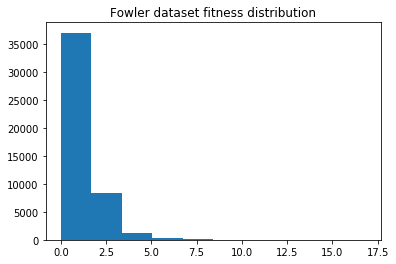

In [50]:
plt.hist(fowler['fitness'])
plt.title("Fowler dataset fitness distribution")
plt.show()

In [48]:
accuracies = normal_learning(fowler_data, fowler['fitness'], train_size=0.7)

KeyboardInterrupt: 

In [ ]:
accuracies[0]

## Data-Augmentation in low-data settings

In [206]:
training_sizes = [100, 300, 500, 1000, 2000, 5000, 10000]
n_components = 100

reg_score_normal = []
reg_score_augmented = []
reg_score_PCA = []
clf_score_normal = []
clf_score_augmented = []

for size in training_sizes:
    aug_run = augmented_learning(fowler_data, fowler_data[:size], fowler['fitness'], n_components, size)
    normal_run = normal_learning(fowler_data, fowler['fitness'], size)
    pca_run = PCA_learning(fowler_data, fowler['fitness'], n_components, size)
    reg_score_normal.append(normal_run[0])
    reg_score_augmented.append(aug_run[0])
    reg_score_PCA.append(pca_run[0])
#     clf_score_normal.append(normal_run[1])
#     clf_score_augmented.append(aug_run[1])

In [220]:
[i[0] for i in reg_score_normal]

[0.23088924713215622,
 0.267905324194388,
 0.28868956549751046,
 0.3578618625493755,
 0.38566115051369765,
 0.41700561112622936,
 0.43087886648885904]

In [219]:
reg_score_normal[0][0]

0.23088924713215622

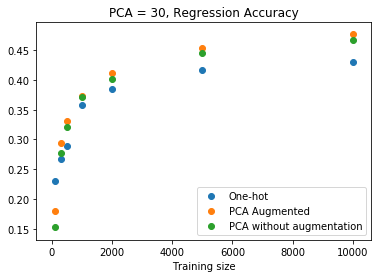

In [223]:
plt.scatter(training_sizes, [i[0] for i in reg_score_normal], label="One-hot")
plt.scatter(training_sizes, [i[0] for i in reg_score_augmented], label="PCA Augmented")
plt.scatter(training_sizes, [i[0] for i in reg_score_PCA], label="PCA without augmentation")

plt.xlabel("Training size")
plt.title("PCA = 30, Regression Accuracy")
plt.legend()
plt.savefig("PCA_30_Reg_WW.png")
plt.show()

In [615]:
w

2

## UMAP Experiments

In [190]:
x_train, x_test, y_train, y_test = split_data(fowler_data, fowler['fitness'], train_size=1000)

In [206]:
pooled_data = np.concatenate([ortholog_data[:1000], x_train])

In [217]:
UMAP_embedding = umap.UMAP(n_neighbors=15,
                      min_dist=0.05,
                      n_components=2,
                      metric='manhattan').fit(pooled_data)

//anaconda/envs/ML_env/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 4 separate connected components using meta-embedding (experimental)
  n_components


In [224]:
xtrain_UMAP = UMAP_embedding.transform(x_train)
xtest_UMAP = UMAP_embedding.transform(x_test)

In [219]:
pooled_UMAP = UMAP_embedding.transform(pooled_data)

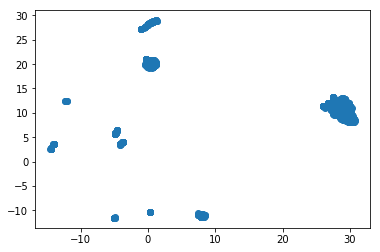

In [221]:
plt.scatter(pooled_UMAP[:, 0], pooled_UMAP[:, 1])
plt.show()

In [225]:
Reg = GradientBoostingRegressor()
Reg.fit(xtrain_UMAP, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [226]:
Reg.score(xtest_UMAP, y_test)

-0.03081163049724811

In [553]:
UMAP_sarkisyan = UMAP_embedding.transform(sarkisyan_data)

In [554]:
# UMAP_sarkisyan = UMAP_embedding.transform(sarkisyan_data)

X_train, X_test, y_train, y_test = train_test_split(UMAP_sarkisyan, sarkisyan['function'], 
                                                   test_size = 0.3, random_state=10)

naiveClf = RandomForestClassifier()
naiveClf.fit(X_train, y_train)
clf_score = naiveClf.score(X_test, y_test)

X_train, X_test, y_train, y_test = train_test_split(UMAP_sarkisyan, sarkisyan['quantitative_function'], 
                                               test_size = 0.3, random_state=10)
naiveReg = RandomForestRegressor()
naiveReg.fit(X_train, y_train)
reg_score = naiveReg.score(X_test, y_test)

//anaconda/envs/ML_env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda/envs/ML_env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [555]:
clf_score

0.5135030615533355

In [556]:
reg_score

-0.24899542340754088

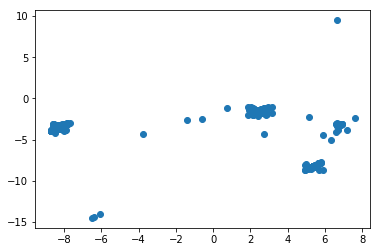

In [558]:
plt.scatter(UMAP_sarkisyan[:,0][:10000], UMAP_sarkisyan[:, 1][:10000])
plt.show()

In [548]:
UMAP_sarkisyan_20 = UMAP_sarkisyan.copy()
ortholog_umap_20 = a.copy()

This concludes the pre-processing we need to do on the data.

## 2.  Training the model
We now move on to define our neural network. This is essentially a vanilla VAE in keras (with some optimization on hyperparameters). For optimization purposes we define a callback function that reports the predictive power of the model in the end of each epoch. Note that while this passes the -test data- through the model, it is kosher because we never pass in the values we are actually interested in and the network is not in "training phase", i.e. no weights are updated during this pass. 

In [54]:
class rho_vs_mutants():
    def __init__(self,mutants,test_set_size,aa_size,sequence_size):
        self.mutants=mutants
        self.sample_size=test_set_size
        self.aa_size=aa_size
        self.sequence_size=sequence_size
        self.scores=[]
        self.count_batch=0
    def on_train_begin(self, logs={}):
        self.losses = []
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
    #This allows us to track the "progress" of the model on different epochs
    def on_epoch_end(self,model,batch,logs):
        x_decoded=model(test_data_plus[0:self.sample_size],batch_size=batch_size)
        digit = x_decoded[0].reshape(self.aa_size,self.sequence_size)
        digit_wt = normalize(digit,axis=0, norm='l1')
        wt_prob=compute_log_probability(digit,digit_wt)
        fitnesses=[]
        for sample in range(1,self.sample_size):
            digit = x_decoded[sample].reshape(self.aa_size,self.sequence_size)
            digit = normalize(digit,axis=0, norm='l1')
            fitness=compute_log_probability(test_data_plus[sample].reshape(self.aa_size,self.sequence_size),digit)-wt_prob
            fitnesses.append(fitness)
        print (","+str(spearmanr(fitnesses,target_values_singles[:self.sample_size-1])))
        self.scores.append(spearmanr(fitnesses,target_values_singles[:self.sample_size-1])[0])

Now we are ready to specify the network architecture, this is adapted from [here](https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py).

In [55]:
# torch.sum(1 + model.z_log_var - (model.z_mean)**2 - torch.exp(model.z_log_var),-1)

In [56]:
PRUNED_SEQ_LENGTH

34

In [166]:
batch_size = 20
original_dim=len(ORDER_LIST)*PRUNED_SEQ_LENGTH
output_dim=len(ORDER_LIST)*PRUNED_SEQ_LENGTH
latent_dim = 30
intermediate_dim=250
nb_epoch = 50
epsilon_std = 1.0
np.random.seed(42)  

loss1 = nn.CrossEntropyLoss()

def vae_loss(x_true, x_decoded_mean, z_mean, z_log_var):
    xent_loss = original_dim * loss1(x_decoded_mean, x_true)
    kl_loss = -0.5 * torch.sum(1 + z_log_var - (z_mean)**2 - torch.exp(z_log_var))
#     print ("xent loss: ", xent_loss)
#     print ("KL loss: ", kl_loss)
    return (xent_loss + kl_loss)

And run it through our training data.

In [58]:
len(range(0, 300)[:20])

20

In [59]:
len(ortholog_data)

16668

In [167]:
training_size = 16600 #so batchingw orks
x_train=ortholog_data[:training_size] #this needs to be divisible by batch size and less than or equal to dataset size
x_train = x_train.astype('float32')
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))


In [168]:
vae_type = 'full'

In [169]:
if vae_type == 'full':
    univ_dropout = [0.2]*3
    dropout_enc = univ_dropout
    dropout_dec = univ_dropout

    layers_enc = nn.ModuleList([nn.Linear(original_dim,intermediate_dim),nn.Dropout(dropout_enc[0]),nn.ELU()])
    for i in range(2):
#     for i in range(1):
        layers_enc.append(nn.Linear(intermediate_dim,intermediate_dim))
        layers_enc.append(nn.Dropout(dropout_enc[i+1]))
        layers_enc.append(nn.ELU())

    layers_dec = nn.ModuleList([nn.Linear(latent_dim,intermediate_dim),nn.Dropout(dropout_dec[0]),nn.ELU()])
    for i in range(2):
        layers_dec.append(nn.Linear(intermediate_dim,intermediate_dim))
        layers_dec.append(nn.Dropout(dropout_dec[i+1]))
        layers_dec.append(nn.ELU())

    layers_dec.append(nn.Linear(intermediate_dim,output_dim))

    layers_ae = nn.ModuleList([nn.Linear(intermediate_dim,latent_dim),nn.Linear(intermediate_dim,latent_dim)])
elif vae_type == 'conv':
    out_conv_enc = [100,100]
    kernels_enc = [6,10]
    out_lin_enc = [200,100]
    dropout_enc = [0.2,0.2]
    
    out_lin_dec = [200,250]
    dropout_dec = [0.2,0.2]
    
    layers_enc_pre_view = nn.ModuleList([nn.Conv1d(len(ORDER_LIST),out_conv_enc[0],kernels_enc[0],stride=1),
                                nn.ELU(),
                                nn.MaxPool1d(4,padding=0),
                                nn.ZeroPad2d((2,3,0,0)),
                                nn.Conv1d(out_conv_enc[0],out_conv_enc[1],kernels_enc[1],stride=1),
                                nn.ELU(),
                                nn.MaxPool1d(3,padding=0)])
    
    enc_view = 100*5
    
    layers_enc_post_view = nn.ModuleList([nn.Linear(enc_view,out_lin_enc[0]),
                                          nn.Dropout(dropout_enc[0]),
                                          nn.ELU(),
                                          nn.Linear(out_lin_enc[0],out_lin_enc[1]),
                                          nn.Dropout(dropout_enc[1]),
                                          nn.ELU()])
    
    layers_dec = nn.ModuleList([nn.Linear(latent_dim,out_lin_dec[0]),
                                nn.Dropout(dropout_dec[0]),
                                nn.ELU(),
                                nn.Linear(out_lin_dec[0],out_lin_dec[1]),
                                nn.Dropout(dropout_dec[1]),
                                nn.ELU(),
                                nn.Linear(out_lin_dec[1],output_dim)])
    
    layers_ae = nn.ModuleList([nn.Linear(out_lin_enc[-1],latent_dim),nn.Linear(out_lin_enc[-1],latent_dim)])
elif vae_type == 'rec':
    univ_dropout = [0.2]*2
    dropout_enc = univ_dropout
    dropout_dec = univ_dropout
#     hid_sizes = [100,100]
    
    layers_enc = nn.ModuleList([nn.RNN(len(ORDER_LIST),1,num_layers=2,batch_first=True,dropout=0.2,bidirectional=True)])
    layers_post_rec_enc = nn.ModuleList([nn.Linear(4,intermediate_dim),
                                         nn.Dropout(dropout_enc[0]),
                                         nn.ELU(),
                                         nn.Linear(intermediate_dim,intermediate_dim),
                                         nn.Dropout(dropout_enc[1]),
                                         nn.ELU()])
    
    
    layers_pre_rec_dec = nn.ModuleList([nn.Linear(latent_dim,100),
                                        nn.Dropout(dropout_dec[0]),
                                        nn.ELU()])
    # 25 below bc bidirectional 2 layers means we have to divide 100 by 2*2
    layers_dec = nn.ModuleList([nn.RNN(50,25,num_layers=2,batch_first=True,dropout=0.2,bidirectional=True)])
    layers_post_rec_dec = nn.ModuleList([nn.Linear(25*2,len(ORDER_LIST))])
    
    layers_ae = nn.ModuleList([nn.Linear(intermediate_dim,latent_dim),nn.Linear(intermediate_dim,latent_dim)])

In [170]:
if vae_type == 'full':
    model = VAE(layers_enc,layers_ae,layers_dec)

    prams = list(model.parameters())

    optimizer = torch.optim.Adam(prams, lr = 0.001)

    x_train_data, x_val_data = train_test_split(x_train, test_size = 0.1)

    ins_train = x_train_data.reshape(len(x_train_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
    ins_train = torch.Tensor(ins_train)
    ins_train = torch.argmax(ins_train,1)

    ins_val = x_val_data.reshape(len(x_val_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
    ins_val = torch.Tensor(ins_val)
    ins_val = torch.argmax(ins_val,1)

    for epoch in range(nb_epoch):
        model.train()

        train = np.random.permutation(x_train_data)
        train = train.reshape(-1,batch_size,PRUNED_SEQ_LENGTH * len(ORDER_LIST))

        train = torch.Tensor(train)

        for batch in train:
            out = model(batch)

            batch = batch.reshape(batch_size*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
            batch = torch.argmax(batch,1)
            out = out.reshape(batch_size*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

            loss = vae_loss(batch,out,model.z_mean,model.z_log_var)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()

        out_train = model(torch.Tensor(x_train_data))
        out_train = torch.Tensor(out_train)
        out_train = out_train.reshape(len(x_train_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

        classpreds_train = torch.argmax(out_train,dim=1)
        bool_train = (classpreds_train==ins_train)
        class_acc_train = bool_train.sum().item()/bool_train.shape[0]

        out_val = model(torch.Tensor(x_val_data))
        out_val = torch.Tensor(out_val)
        out_val = out_val.reshape(len(x_val_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

        classpreds_val = torch.argmax(out_val,dim=1)
        bool_val = (classpreds_val==ins_val)
        class_acc_val = bool_val.sum().item()/bool_val.shape[0]

        loss_train = vae_loss(ins_train,out_train,model.z_mean,model.z_log_var)
        loss_val = vae_loss(ins_val,out_val,model.z_mean,model.z_log_var)

        print('Epoch %s | Training Loss: %s, Training Accuracy: %s, Validation Loss: %s, Validation Accuracy: %s'
              %( epoch, loss_train.item(), class_acc_train, loss_val.item(), class_acc_val ) )

elif vae_type == 'conv':
    model = VAE_conv(layers_enc_pre_view,enc_view,layers_enc_post_view,layers_ae,layers_dec)
        
    prams = list(model.parameters())

    optimizer = torch.optim.Adam(prams, lr = 0.001)

    x_train_data, x_val_data = train_test_split(x_train, test_size = 0.1)

    ins_train = x_train_data.reshape(len(x_train_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
    ins_train = torch.Tensor(ins_train)
    ins_train = torch.argmax(ins_train,1)

    ins_val = x_val_data.reshape(len(x_val_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
    ins_val = torch.Tensor(ins_val)
    ins_val = torch.argmax(ins_val,1)

    for epoch in range(nb_epoch):
        model.train()

        train = np.random.permutation(x_train_data)
        train = train.reshape(-1,batch_size,PRUNED_SEQ_LENGTH,len(ORDER_LIST))

        train = torch.Tensor(train)
        train = train.transpose(-2,-1)

        for batch in train:
            out = model(batch)

            batch = batch.transpose(-2,-1).reshape(batch_size*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
            batch = torch.argmax(batch,1)
            out = out.reshape(batch_size*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

            loss = vae_loss(batch,out,model.z_mean,model.z_log_var)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()

        out_train = model(torch.Tensor(x_train_data).reshape(-1,PRUNED_SEQ_LENGTH,len(ORDER_LIST)).transpose(-2,-1))
        out_train = torch.Tensor(out_train)
        out_train = out_train.reshape(len(x_train_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

        classpreds_train = torch.argmax(out_train,dim=1)
        bool_train = (classpreds_train==ins_train)
        class_acc_train = bool_train.sum().item()/bool_train.shape[0]

        out_val = model(torch.Tensor(x_val_data).reshape(-1,PRUNED_SEQ_LENGTH,len(ORDER_LIST)).transpose(-2,-1))
        out_val = torch.Tensor(out_val)
        out_val = out_val.reshape(len(x_val_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

        classpreds_val = torch.argmax(out_val,dim=1)
        bool_val = (classpreds_val==ins_val)
        class_acc_val = bool_val.sum().item()/bool_val.shape[0]

        loss_train = vae_loss(ins_train,out_train,model.z_mean,model.z_log_var)
        loss_val = vae_loss(ins_val,out_val,model.z_mean,model.z_log_var)

        print('Epoch %s | Training Loss: %s, Training Accuracy: %s, Validation Loss: %s, Validation Accuracy: %s'
              %( epoch, loss_train.item(), class_acc_train, loss_val.item(), class_acc_val ) )
        
elif vae_type == 'rec':
    model = VAE_rec(layers_enc,layers_post_rec_enc,layers_ae,layers_pre_rec_dec,layers_dec,layers_post_rec_dec)
    
    prams = list(model.parameters())

    optimizer = torch.optim.Adam(prams, lr = 0.001)

    x_train_data, x_val_data = train_test_split(x_train, test_size = 0.1)

    ins_train = x_train_data.reshape(len(x_train_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
    ins_train = torch.Tensor(ins_train)
    ins_train = torch.argmax(ins_train,1)

    ins_val = x_val_data.reshape(len(x_val_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
    ins_val = torch.Tensor(ins_val)
    ins_val = torch.argmax(ins_val,1)

    for epoch in range(nb_epoch):
        model.train()

        train = np.random.permutation(x_train_data)
        train = train.reshape(-1,batch_size,PRUNED_SEQ_LENGTH,len(ORDER_LIST))

        train = torch.Tensor(train)
#         train = train.transpose(-2,-1)

        for batch in train:
            out = model(batch)

            batch = batch.transpose(-2,-1).reshape(batch_size*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
            batch = torch.argmax(batch,1)
            out = out.reshape(batch_size*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

            loss = vae_loss(batch,out,model.z_mean,model.z_log_var)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()

        out_train = model(torch.Tensor(x_train_data).reshape(-1,PRUNED_SEQ_LENGTH,len(ORDER_LIST)))
        out_train = torch.Tensor(out_train)
        out_train = out_train.reshape(len(x_train_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

        classpreds_train = torch.argmax(out_train,dim=1)
        bool_train = (classpreds_train==ins_train)
        class_acc_train = bool_train.sum().item()/bool_train.shape[0]

        out_val = model(torch.Tensor(x_val_data).reshape(-1,PRUNED_SEQ_LENGTH,len(ORDER_LIST)))
        out_val = torch.Tensor(out_val)
        out_val = out_val.reshape(len(x_val_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

        classpreds_val = torch.argmax(out_val,dim=1)
        bool_val = (classpreds_val==ins_val)
        class_acc_val = bool_val.sum().item()/bool_val.shape[0]

        loss_train = vae_loss(ins_train,out_train,model.z_mean,model.z_log_var)
        loss_val = vae_loss(ins_val,out_val,model.z_mean,model.z_log_var)

        print('Epoch %s | Training Loss: %s, Training Accuracy: %s, Validation Loss: %s, Validation Accuracy: %s'
              %( epoch, loss_train.item(), class_acc_train, loss_val.item(), class_acc_val ) )

Epoch 0 | Training Loss: 8228.267578125, Training Accuracy: 0.8638042365540594, Validation Loss: 8224.8359375, Validation Accuracy: 0.8648476257973069
Epoch 1 | Training Loss: 10068.8193359375, Training Accuracy: 0.8973639656665879, Validation Loss: 10066.1806640625, Validation Accuracy: 0.897165131112686
Epoch 2 | Training Loss: 10541.095703125, Training Accuracy: 0.9153122293093945, Validation Loss: 10536.2939453125, Validation Accuracy: 0.915024805102764
Epoch 3 | Training Loss: 12167.8955078125, Training Accuracy: 0.922578549492086, Validation Loss: 12164.4228515625, Validation Accuracy: 0.9240432317505315
Epoch 4 | Training Loss: 11891.0400390625, Training Accuracy: 0.9309610992991574, Validation Loss: 11886.36328125, Validation Accuracy: 0.9331148121899362
Epoch 5 | Training Loss: 12596.791015625, Training Accuracy: 0.9308705409874793, Validation Loss: 12595.2548828125, Validation Accuracy: 0.9301027639971652
Epoch 6 | Training Loss: 12373.6279296875, Training Accuracy: 0.9355716

Let's explore the latent space

In [173]:
fit_xtrain = model(torch.Tensor(x_train)).detach()
z_means = model.z_mean.detach()

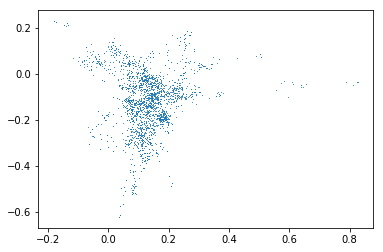

In [174]:
transposed_zmeans = np.array(z_means).transpose()

plt.scatter(transposed_zmeans[0], transposed_zmeans[1], s = 1, linewidths = 0)
plt.show()

In [175]:
from sklearn.cluster import KMeans

z_means_np = np.array(z_means)
kmeans = KMeans(n_clusters=12, random_state=1).fit(z_means_np)

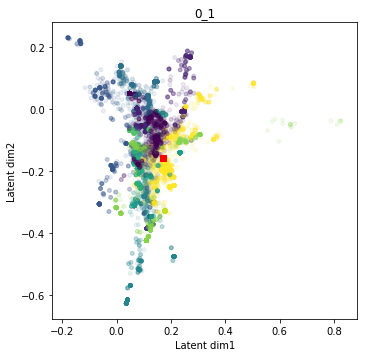

In [176]:
sample_points=len(z_means_np)

latent_dim = 2
fig = plt.figure(figsize=(12,12))
counter=0
cmap=kmeans.labels_
for z1 in range(latent_dim):
    for z2 in range(z1+1,latent_dim):
        counter+=1
        fig.add_subplot(latent_dim,latent_dim,counter)
        plt.title(str(z1)+"_"+str(z2))
        plt.scatter(z_means_np[:, z1][::-1], z_means_np[:, z2][::-1],c=cmap[::-1], s = 15, alpha=0.1,marker="o")
#         plt.scatter(z_means_np[:, z1][::-1], z_means_np[:, z2][::-1],c="y" ,alpha=0.3,marker="o")
        plt.scatter(z_means_np[0][z1], z_means_np[0][z2],c="r" ,alpha=1,s=40,marker="s")
        plt.xlabel("Latent dim"+str(z1+1))
        plt.ylabel("Latent dim"+str(z2+1));
plt.savefig("Try2_originalDropout.png")


In [90]:
plt.pcolor(x_train[0].reshape(238, 25).transpose(1, 0))
plt.show()

ValueError: cannot reshape array of size 850 into shape (238,25)

# Training a classifier over the latent space

In [177]:
fit_total = model(torch.Tensor(fowler_data)).detach()
latent_data = model.z_mean.detach()

In [178]:
fit_total.shape

torch.Size([47000, 850])

In [179]:
latent_data.shape

torch.Size([47000, 30])

In [ ]:
fit_total

In [188]:
X_train, X_test, y_train, y_test = train_test_split(np.array(latent_data), fowler['fitness'], 
                                                   test_size = 0.3, random_state=10)

In [189]:
latentReg = GradientBoostingRegressor()
latentReg.fit(X_train, y_train)
# latentReg.predict(X_test)
latentReg.score(X_test, y_test)

0.08998728689281697

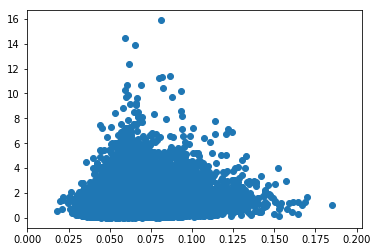

In [190]:
plt.scatter(X_train[:,0], y_train)
plt.show()

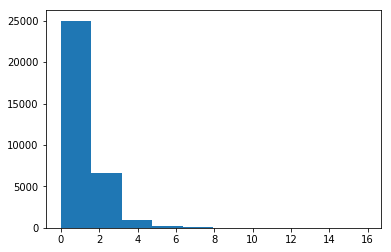

In [191]:
plt.hist(y_train)
plt.show()

In [192]:
px_data = np.concatenate([np.array(fitnesses).reshape(-1, 1), np.array(fitnesses_vs_wt).reshape(-1, 1),
                                                                       np.array(fitnesses_vs_avg).reshape(-1, 1)], axis = 1)

In [193]:
total_data = np.concatenate([latent_data, torch.Tensor(px_data)], axis = 1)

In [233]:
X_train, X_test, y_train, y_test = train_test_split(np.array(total_data), fowler['fitness'], 
                                                   train_size = 5000, random_state=10)

latentReg = GradientBoostingRegressor()
latentReg.fit(X_train, y_train)
# latentReg.predict(X_test)
latentReg.score(X_test, y_test)

0.0549065229232445

In [234]:
spearmanr(latentReg.predict(X_test), y_test)

SpearmanrResult(correlation=0.2865505901158867, pvalue=0.0)

## Calculating P(X)

In [180]:
m = torch.nn.Softmax()

In [181]:
PRUNED_SEQ_LENGTH

34

In [182]:
reshaped_fit = np.array(m(fit_total.reshape(len(fit_total) * PRUNED_SEQ_LENGTH, 
                                            len(ORDER_LIST))).reshape(len(fit_total), PRUNED_SEQ_LENGTH, len(ORDER_LIST))
                        .transpose(2, 1))







//anaconda/envs/ML_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


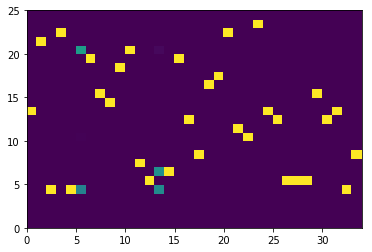

In [183]:
plt.pcolor(reshaped_fit[0])

In [184]:
fit_total.shape

torch.Size([47000, 850])

In [185]:
len(ORDER_LIST)

25

In [186]:
digit_wt

array([[1.14095748e-16, 1.37655204e-17, 6.02574673e-17, 8.13176379e-17,
        2.72435283e-16, 1.67925619e-16, 6.19252553e-16, 2.61197962e-16,
        2.05025317e-17, 2.22050911e-17, 3.06512133e-16, 1.22057919e-17,
        1.81302125e-17, 1.43526927e-16, 1.56072928e-16, 1.66621730e-16,
        6.01909553e-18, 1.91052463e-16, 4.71980721e-17, 3.29097082e-17,
        3.72604500e-17, 1.20943414e-16, 3.15064757e-16, 3.64985240e-17,
        5.55894753e-17, 2.55496927e-16, 2.85472470e-16, 2.68636565e-17,
        2.35130565e-15, 1.36884773e-16, 7.97937726e-17, 2.05973915e-16,
        2.21628619e-17, 4.97098921e-17],
       [1.61379878e-03, 4.47482103e-04, 2.02048407e-03, 8.33142491e-04,
        5.32787177e-04, 7.56647380e-04, 1.65428594e-03, 6.79734454e-04,
        1.14066713e-03, 6.97216478e-07, 1.00258247e-16, 3.94164102e-17,
        3.23758968e-16, 7.80773834e-10, 1.32436714e-15, 3.05073975e-08,
        1.56388550e-19, 2.05390496e-08, 2.28195418e-07, 5.72104959e-08,
        1.13199164e-07,

In [187]:
sample_size=len(fit_total)
sample_for_averging_size=100
sequence_size=PRUNED_SEQ_LENGTH
digit_size = len(ORDER_LIST)

digit = reshaped_fit[0]#fit_xtrain_softmax_reshaped[0]
digit_wt = digit
digit_wt = normalize(digit,axis=0, norm='l1')
# print (digit_wt)


wt_prob=compute_log_probability(reshaped_fit[0].reshape(digit_size, sequence_size),digit_wt)
#print ("wt_log_prob: ", wt_prob)

wt_probs=[]
digit_avg=np.zeros((digit_size, sequence_size))


sample_indices=random.sample(range(sample_size),sample_for_averging_size)

counter=0
for sample in sample_indices:
    digit = reshaped_fit[sample]
#     print (digit)
#     print (digit_avg)
#     digit_wt_i = normalize(digit,axis=0, norm='l1')
    digit_wt_i = digit
    
#     print (digit_wt_i)
    
    digit_avg+=np.array(digit_wt_i) * 1. / sample_for_averging_size
    
    wt_p=compute_log_probability(reshaped_fit[sample].reshape(digit_size, sequence_size),digit_wt_i)
    wt_probs.append(wt_p)
    counter+=1
    
average_wt_p=np.mean(wt_probs)

fitnesses_vs_wt=[]
fitnesses=[] #first plug in just the sequences
fitnesses_vs_avg=[] 

for sample in range(0,sample_size):
    digit = reshaped_fit[sample]
#     digit = normalize(digit,axis=0, norm='l1')
    
    fitness=compute_log_probability(reshaped_fit[sample].reshape(digit_size, sequence_size),digit)-wt_prob
    fitnesses.append(fitness)
    
    fitness=compute_log_probability(reshaped_fit[sample].reshape(digit_size, sequence_size),digit_wt)-wt_prob
    fitnesses_vs_wt.append(fitness)
    
    fitness=compute_log_probability(reshaped_fit[sample].reshape(digit_size, sequence_size),digit_avg)-average_wt_p
    fitnesses_vs_avg.append(fitness)
    
    
test_data = fowler['fitness']
print ("Spearman",spearmanr(fitnesses_vs_avg,test_data[:sample_size]))
print ("Pearson", pearsonr(fitnesses_vs_avg,test_data[:sample_size]))
print ('------------------------------')
print ("Spearman",spearmanr(fitnesses_vs_wt,test_data[:sample_size]))
print ("Pearson", pearsonr(fitnesses_vs_wt,test_data[:sample_size]))
print ('------------------------------')
print ("Spearman",spearmanr(fitnesses,test_data[:sample_size]))
print ("Pearson", pearsonr(fitnesses,test_data[:sample_size]))

Spearman SpearmanrResult(correlation=-0.14729083246193647, pvalue=3.601933264807301e-226)
Pearson (-0.04120345363786304, 4.025895248209853e-19)
------------------------------
Spearman SpearmanrResult(correlation=-0.20387870711338543, pvalue=0.0)
Pearson (-0.06307877643874023, 1.1906808750176592e-42)
------------------------------
Spearman SpearmanrResult(correlation=-0.17736242051829407, pvalue=0.0)
Pearson (-0.08053773977783493, 1.7650292022973482e-68)


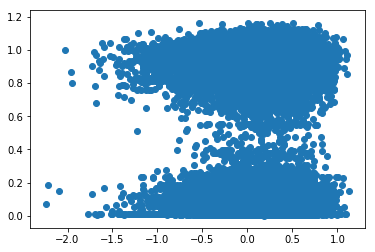

In [835]:
plt.scatter(fitnesses_vs_wt, sarkisyan['quantitative_function'][1:sample_size])

In [825]:
reshaped_fit_sarkisyan[0].reshape(digit_size, sequence_size).T

AttributeError: 'Tensor' object has no attribute 'T'